In [67]:
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm

np.set_printoptions(suppress=True)

In [4]:
project = Path(".").resolve()
data_dir = project / "data"
close_college_path = data_dir / "close_college.dta"

In [7]:
assert path.exists(close_college_path)

In [8]:
close_college = pd.read_stata(close_college_path)

In [10]:
close_college.head()

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


# No Missing Data

In [18]:
close_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nearc4   3010 non-null   int8   
 1   educ     3010 non-null   int8   
 2   black    3010 non-null   int8   
 3   smsa     3010 non-null   int8   
 4   south    3010 non-null   int8   
 5   married  3003 non-null   float64
 6   exper    3010 non-null   int8   
 7   lwage    3010 non-null   float32
dtypes: float32(1), float64(1), int8(6)
memory usage: 53.0 KB


In [39]:
close_college.isnull().sum()

nearc4     0
educ       0
black      0
smsa       0
south      0
married    7
exper      0
lwage      0
dtype: int64

In [40]:
close_college[close_college.married.isnull()]

,nearc4,educ,black,smsa,south,married,exper,lwage
793,1,12,1,1,0,NaN,16,6.551080
1287,0,16,0,0,0,NaN,2,5.953243
2150,1,11,1,1,0,NaN,7,6.684612
2340,0,12,0,0,0,NaN,6,6.606650
2378,0,14,0,1,0,NaN,7,5.857933
2828,0,9,1,0,1,NaN,12,5.926926
2839,0,10,1,1,1,NaN,8,5.298317


In [43]:
close_college.married = close_college.married.fillna(-1)

# Correlations in the data

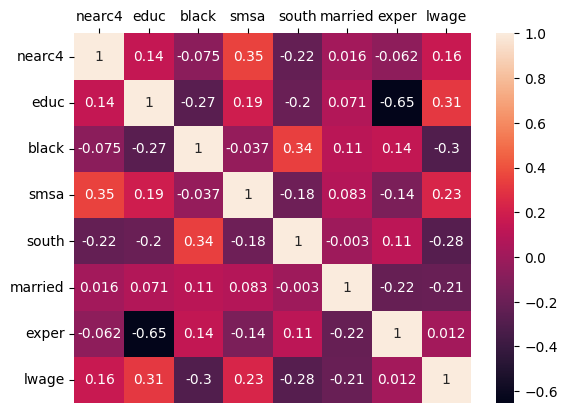

In [17]:
ax = sns.heatmap(close_college.corr(), annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [25]:
correlations = (
    close_college
    .corr()
    .reset_index()
    .rename(columns={"index": "variable_x"})
    .melt(id_vars="variable_x", var_name="variable_y", value_name="correlation")
    .query("variable_x != variable_y")
)

In [28]:
correlations["abs_corr"] = correlations.apply(lambda x: abs(x["correlation"]), axis=1)

In [33]:
correlations.sort_values(by="abs_corr", ascending=False)[["variable_x", "variable_y", "correlation"]]

,variable_x,variable_y,correlation
49,educ,exper,-0.652956
14,exper,educ,-0.652956
3,smsa,nearc4,0.353731
24,nearc4,smsa,0.353731
20,south,black,0.341267
34,black,south,0.341267
15,lwage,educ,0.314224
57,educ,lwage,0.314224
23,lwage,black,-0.303206
58,black,lwage,-0.303206


In [35]:
vif_data = pd.DataFrame() 
vif_data["feature"] = close_college.columns 


In [44]:
vif_data["VIF"] = [variance_inflation_factor(close_college.values, i) for i in range(len(close_college.columns))] 

In [45]:
vif_data

,feature,VIF
0,nearc4,3.724809
1,educ,53.274831
2,black,1.547557
3,smsa,4.233054
4,south,1.971181
5,married,2.266196
6,exper,10.578257
7,lwage,92.866617


In [61]:
x = sm.add_constant(close_college[[col for col in close_college.columns if col != "lwage"]])
y = close_college.lwage
model = sm.OLS(y.astype(float), x.astype(float)).fit()

In [65]:


#create instance of influence
influence = model.get_influence()
cooks = influence.cooks_distance
plt.figure(figsize = (12, 8))
plt.scatter(close_college.index, cooks[0])
plt.plot(close_college.index, cooks[0], color='black')
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influential Points', fontsize = 22)
plt.show()

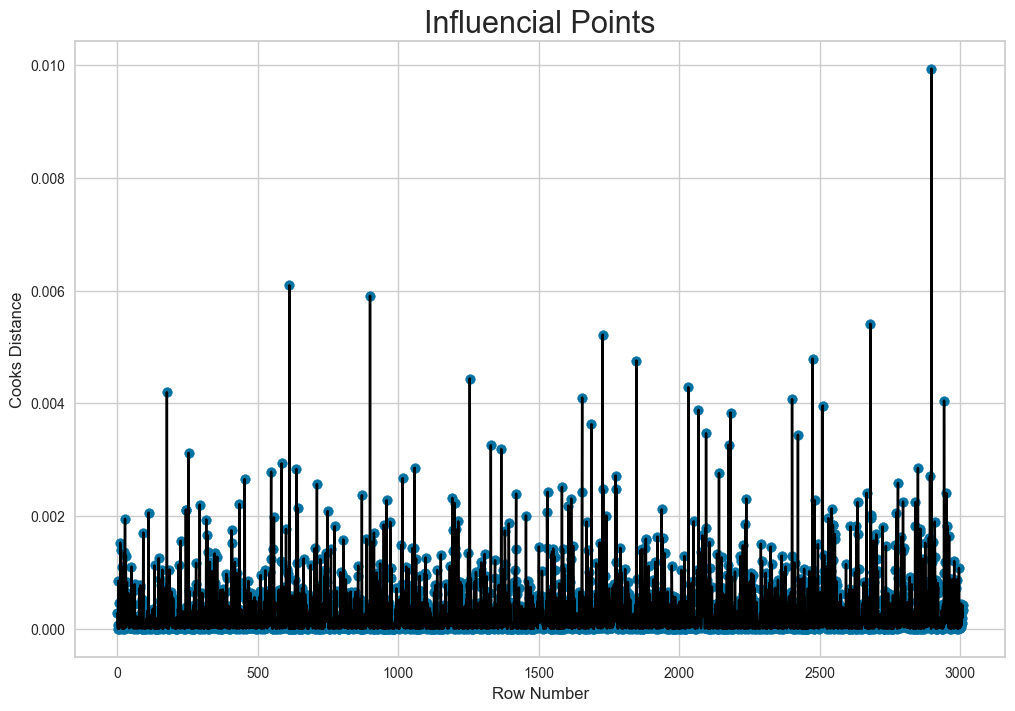